In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from viz_utils import *

In [2]:
experiments, meta = load_results(base_dir="results/", dataset="IMDB", model="JWA")
samplers = list(experiments.keys())
df_tr, df_agr, df_crt_train, df_crt_test = results_to_df(experiments, meta, mode="last")

In [12]:
def df_agr_average(df, groupby=["al_iter", "sampler", "interpreter"]):
    grouped = df.groupby(groupby)
    new_df = pd.DataFrame()
    new_df["correlation"] = grouped.correlation.apply(np.mean)
    new_df["aggrement"] = grouped.agreement.agg('mean')
    new_df["labeled"] = grouped.labeled.agg('min')
    return new_df

In [17]:
corr = agr[agr.labeled==10050].correlation

In [18]:
corr

al_iter  sampler  interpreter               
10       entropy  (deeplift, deeplift-shap)     [0.999859296482412, 0.9997587939698491, 0.9997...
                  (deeplift, grad-shap)         [0.5919396984924623, 0.32016080402010044, 0.37...
                  (deeplift, int-grad)          [0.5989145728643216, 0.4596984924623115, 0.422...
                  (deeplift-shap, grad-shap)    [0.5918391959798994, 0.32036180904522615, 0.37...
                  (deeplift-shap, int-grad)     [0.5988542713567838, 0.459859296482412, 0.4225...
                  (grad-shap, int-grad)         [0.7938693467336683, 0.6450653266331658, 0.601...
         random   (deeplift, deeplift-shap)     [0.9998190954773868, 0.9997386934673367, 0.999...
                  (deeplift, grad-shap)         [0.5660904522613066, 0.3431959798994975, 0.425...
                  (deeplift, int-grad)          [0.5520804020100502, 0.46942713567839184, 0.47...
                  (deeplift-shap, grad-shap)    [0.566070351758794, 0.343

In [22]:
crt = df_crt_test[df_crt_test.index.get_level_values(1) == 10]
crt

,,correctness,confidence,variability,forgetfulness,threshold_closeness
sampler,al_iter,,,,,
entropy,10,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 0.0, ...","[0.8087179, 0.93512076, 0.9816328, 0.9071022, ...","[0.18544905, 0.077013746, 0.028200168, 0.11066...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1000....","[0.15002403, 0.056613285, 0.017984165, 0.08092..."
random,10,"[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 3.0, 0.0, ...","[0.8895391, 0.9183754, 0.97807014, 0.843365, 0...","[0.14093748, 0.09901734, 0.03700342, 0.1973425...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1000....","[0.09775278, 0.074401855, 0.021394366, 0.11362..."


In [44]:
from scipy.stats import pearsonr


for sampler in ["random", "entropy"]:
    corr_s = corr[corr.index.get_level_values("sampler") == sampler]
    crt_s = crt[crt.index.get_level_values("sampler") == sampler]
    for i, vals in enumerate(corr_s):
        print({corr_s.index[i]})
        print(f"\t Correctness: {pearsonr(vals, crt_s.correctness[0])}")
        print(f"\t Confidence: {pearsonr(vals, crt_s.confidence[0])}")
        print(f"\t Variability: {pearsonr(vals, crt_s.variability[0])}")
        print(f"\t Forgetfulness: {pearsonr(vals, crt_s.forgetfulness[0])}")
        print(f"\t Threshold closeness: {pearsonr(vals, crt_s.threshold_closeness[0])}")

{(10, 'random', ('deeplift', 'deeplift-shap'))}
	 Correctness: (-0.04255406005304533, 0.004934302769087747)
	 Confidence: (-0.061712443611195135, 4.522737943687377e-05)
	 Variability: (0.0927647465295629, 8.310783631278719e-10)
	 Forgetfulness: (0.005414921785222722, 0.720663626353374)
	 Threshold closeness: (0.0955011271007073, 2.6024596515379715e-10)
{(10, 'random', ('deeplift', 'grad-shap'))}
	 Correctness: (-0.264685712423158, 7.508493441509518e-71)
	 Confidence: (-0.3495228711872088, 1.4073800648611272e-125)
	 Variability: (0.45224106983371604, 5.5733325954996835e-219)
	 Forgetfulness: (0.06971893640202584, 4.037640410232044e-06)
	 Threshold closeness: (0.48438018376597103, 1.5328477390470463e-255)
{(10, 'random', ('deeplift', 'int-grad'))}
	 Correctness: (-0.3469456757084542, 1.2188658403044558e-123)
	 Confidence: (-0.45255805586115505, 2.5369829265985315e-219)
	 Variability: (0.5902516577616596, 0.0)
	 Forgetfulness: (0.09174540871036907, 1.2701241659926575e-09)
	 Threshold clos

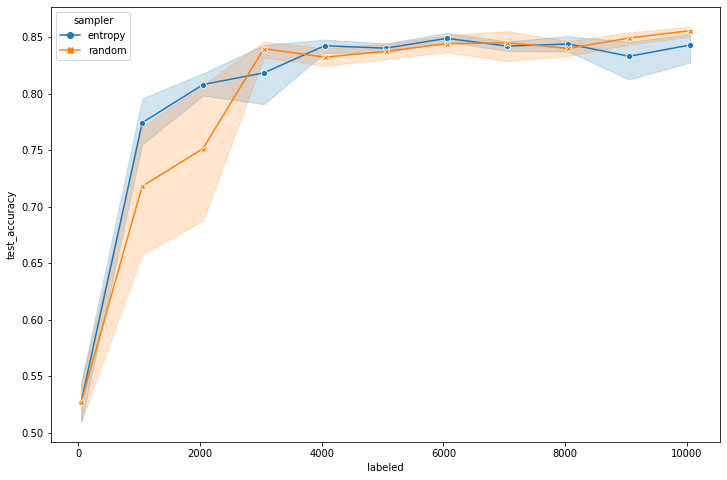

In [4]:
plot_al_accuracy(df_tr, ci=90)

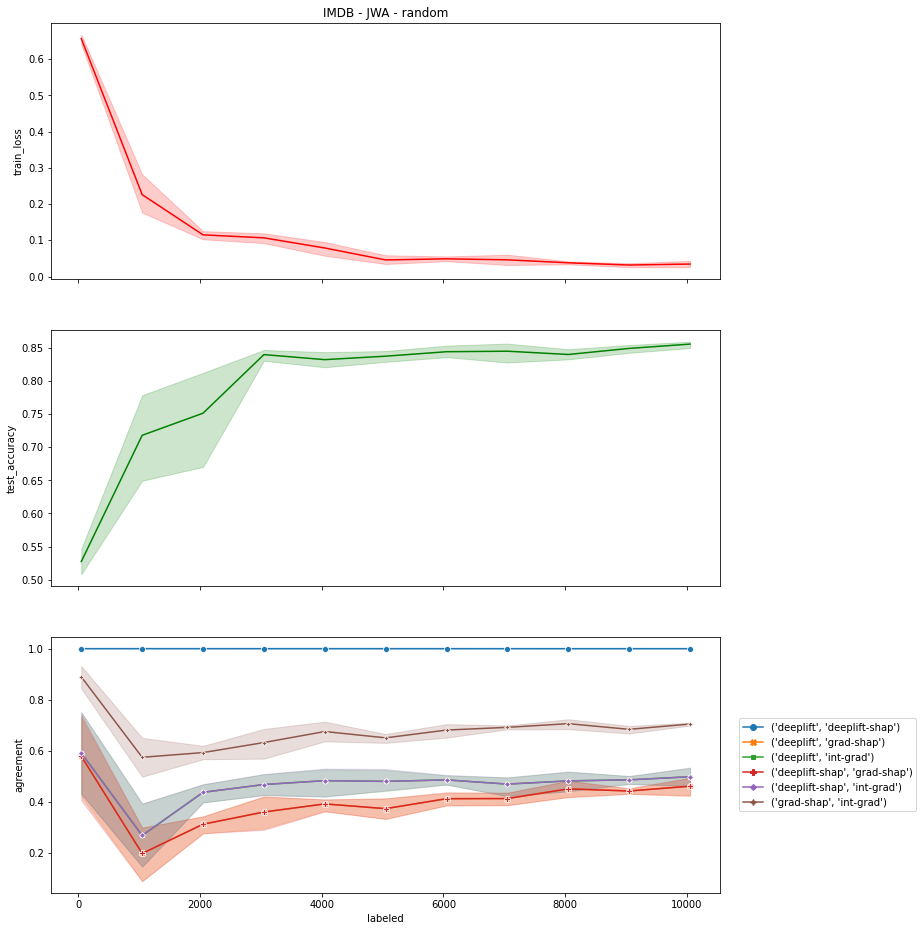

In [4]:
plot_experiment_set(df_tr, df_agr, meta, "random")

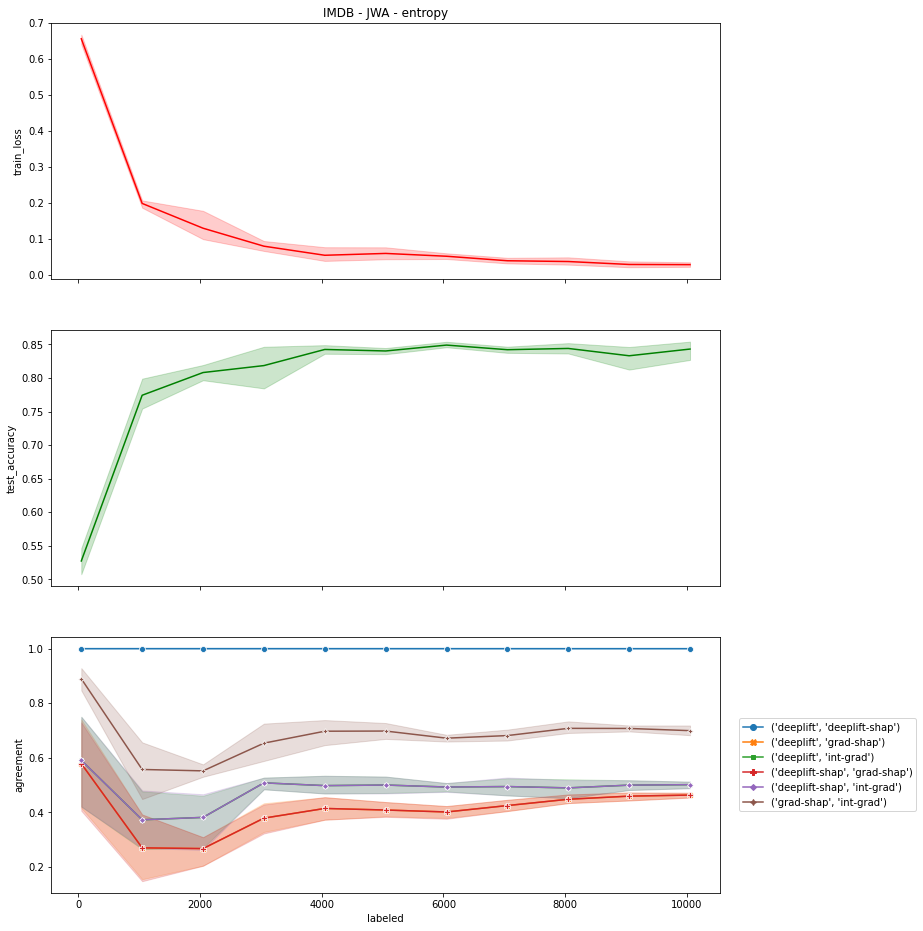

In [5]:
plot_experiment_set(df_tr, df_agr, meta, "entropy")

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [28]:
def df_average(df, groupby=["al_iter", "sampler"]):
    new_df = df.groupby(groupby).aggregate('mean')
    new_df.labeled = new_df.labeled.astype(int)
    return new_df

In [30]:
df_avg = average_df(df_tr)

In [31]:
df_avg

labeled  train_loss  test_accuracy
al_iter sampler                                    
0       entropy       50    0.656629       0.527389
        random        50    0.656629       0.527389
1       entropy     1050    0.199001       0.774284
        random      1050    0.226029       0.718038
2       entropy     2050    0.130148       0.808114
        random      2050    0.115017       0.751455
3       entropy     3050    0.080189       0.818474
        random      3050    0.106756       0.839927
4       entropy     4050    0.054944       0.842494
        random      4050    0.078755       0.832317
5       entropy     5050    0.060063       0.840248
        random      5050    0.045781       0.837543
6       entropy     6050    0.052225       0.849003
        random      6050    0.048844       0.844281
7       entropy     7050    0.039704       0.842127
        random      7050    0.046072       0.845061
8       entropy     8050    0.037562       0.844006
        random      8050    0.037864       0.840110
9       entropy     9050    0.029376       0.833096
        random      9050    0.031760       0.849278
10      entropy    10050    0.028879       0.843090
        random     10050    0.034435       0.855787

In [14]:
df_tr

labeled  train_loss  test_accuracy  sampler
experiment al_iter                                             
0          0             50    0.672345       0.498739  entropy
           1           1050    0.176514       0.757965  entropy
           2           2050    0.222881       0.797387  entropy
           3           3050    0.091616       0.755444  entropy
           4           4050    0.098119       0.836580  entropy
...                     ...         ...            ...      ...
4          6           6050    0.051663       0.851708   random
           7           7050    0.032887       0.848040   random
           8           8050    0.040243       0.835205   random
           9           9050    0.021466       0.836122   random
           10         10050    0.021430       0.844144   random

[110 rows x 4 columns]

In [13]:
df_avg

labeled  train_loss  test_accuracy
al_iter sampler                                    
0       entropy     50.0    0.656629       0.527389
        random      50.0    0.656629       0.527389
1       entropy   1050.0    0.199001       0.774284
        random    1050.0    0.226029       0.718038
2       entropy   2050.0    0.130148       0.808114
        random    2050.0    0.115017       0.751455
3       entropy   3050.0    0.080189       0.818474
        random    3050.0    0.106756       0.839927
4       entropy   4050.0    0.054944       0.842494
        random    4050.0    0.078755       0.832317
5       entropy   5050.0    0.060063       0.840248
        random    5050.0    0.045781       0.837543
6       entropy   6050.0    0.052225       0.849003
        random    6050.0    0.048844       0.844281
7       entropy   7050.0    0.039704       0.842127
        random    7050.0    0.046072       0.845061
8       entropy   8050.0    0.037562       0.844006
        random    8050.0    0.037864       0.840110
9       entropy   9050.0    0.029376       0.833096
        random    9050.0    0.031760       0.849278
10      entropy  10050.0    0.028879       0.843090
        random   10050.0    0.034435       0.855787

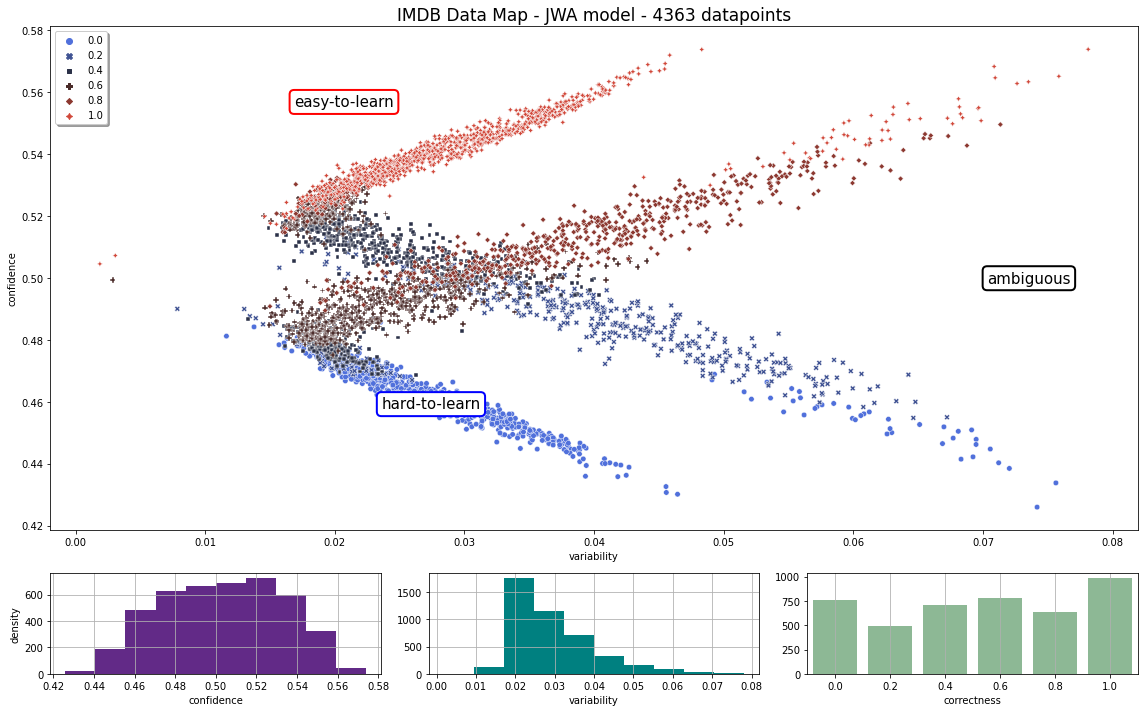

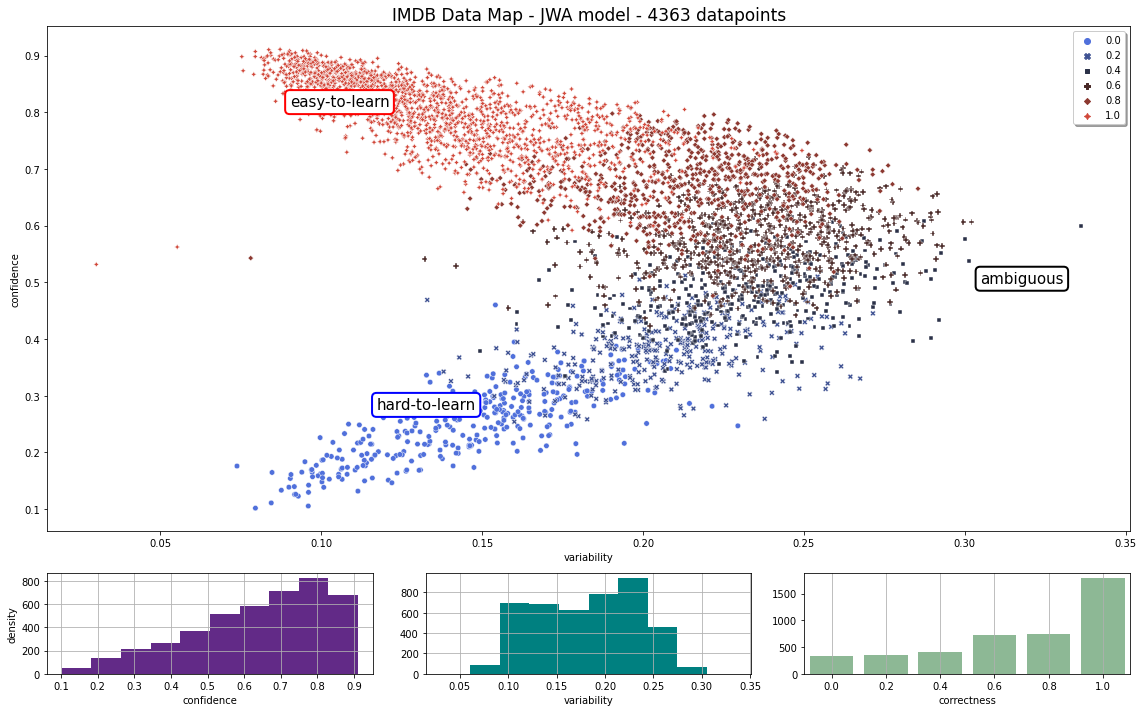

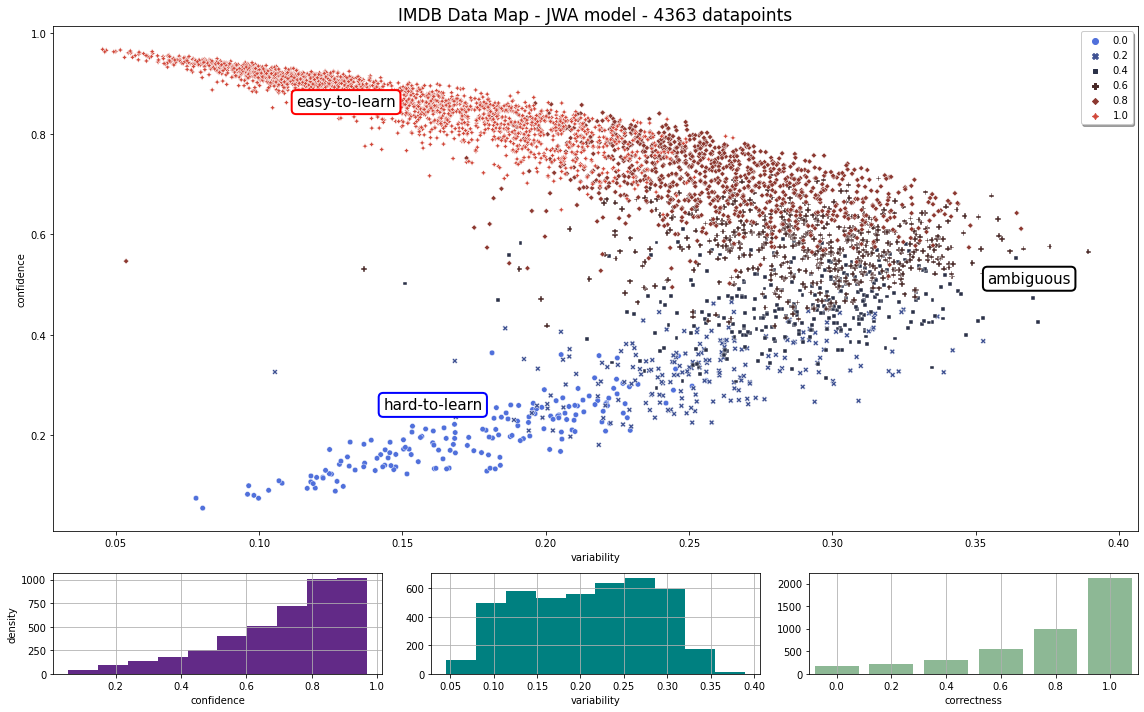

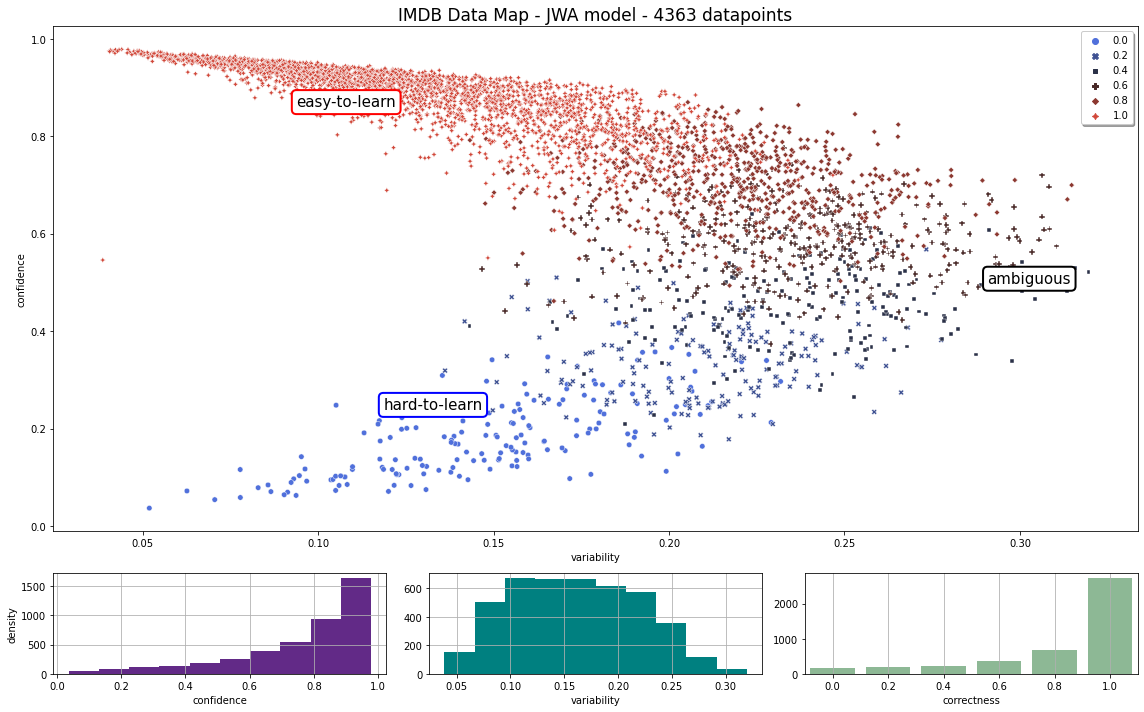

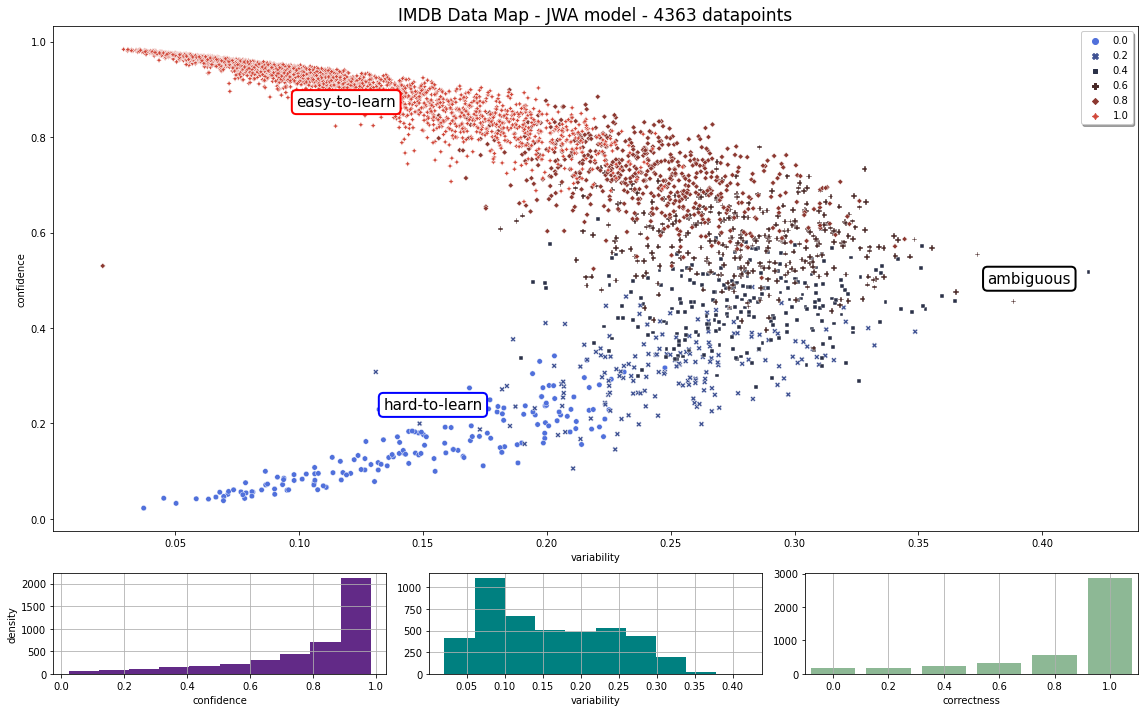

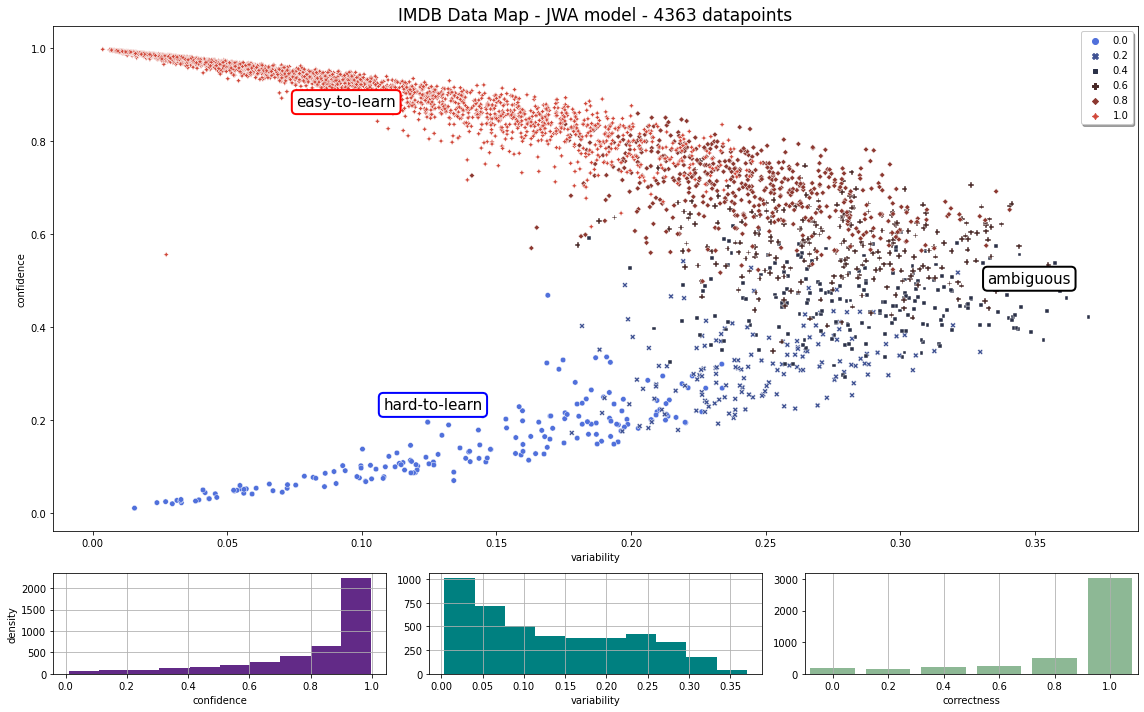

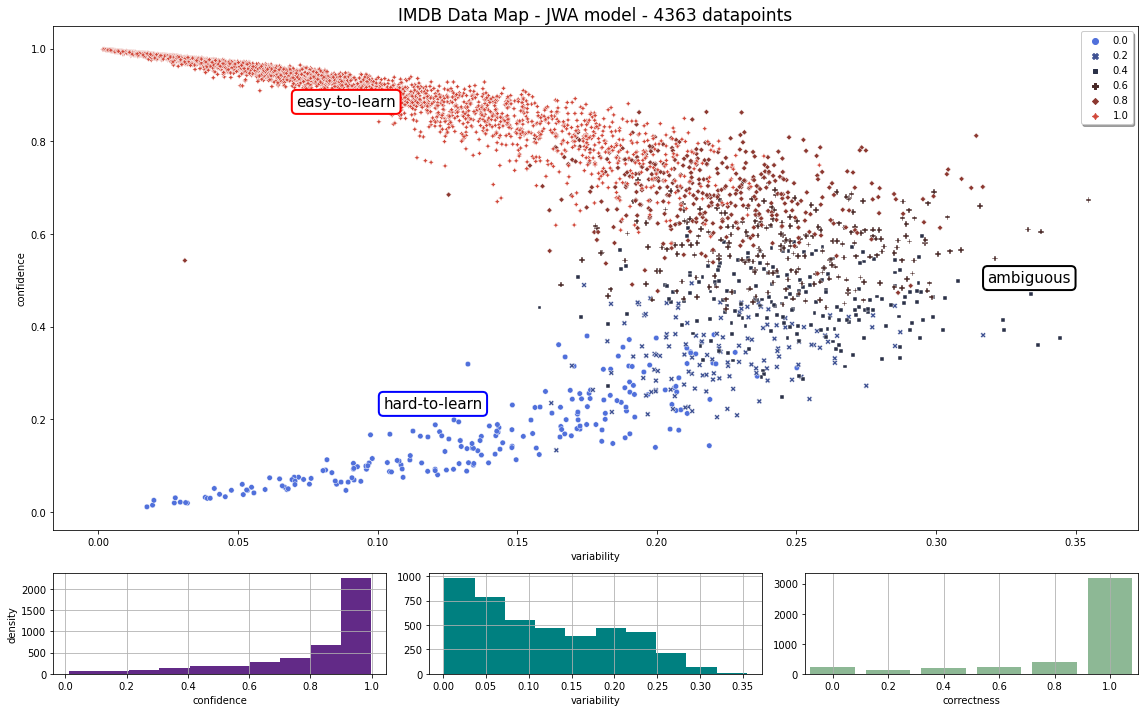

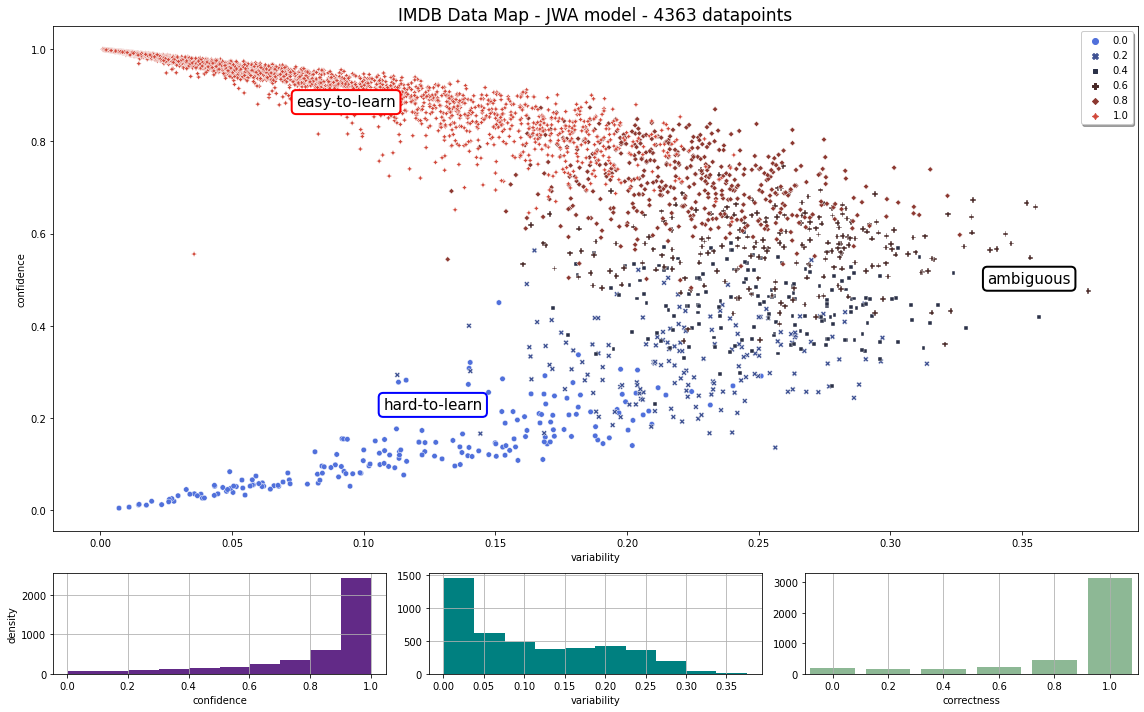

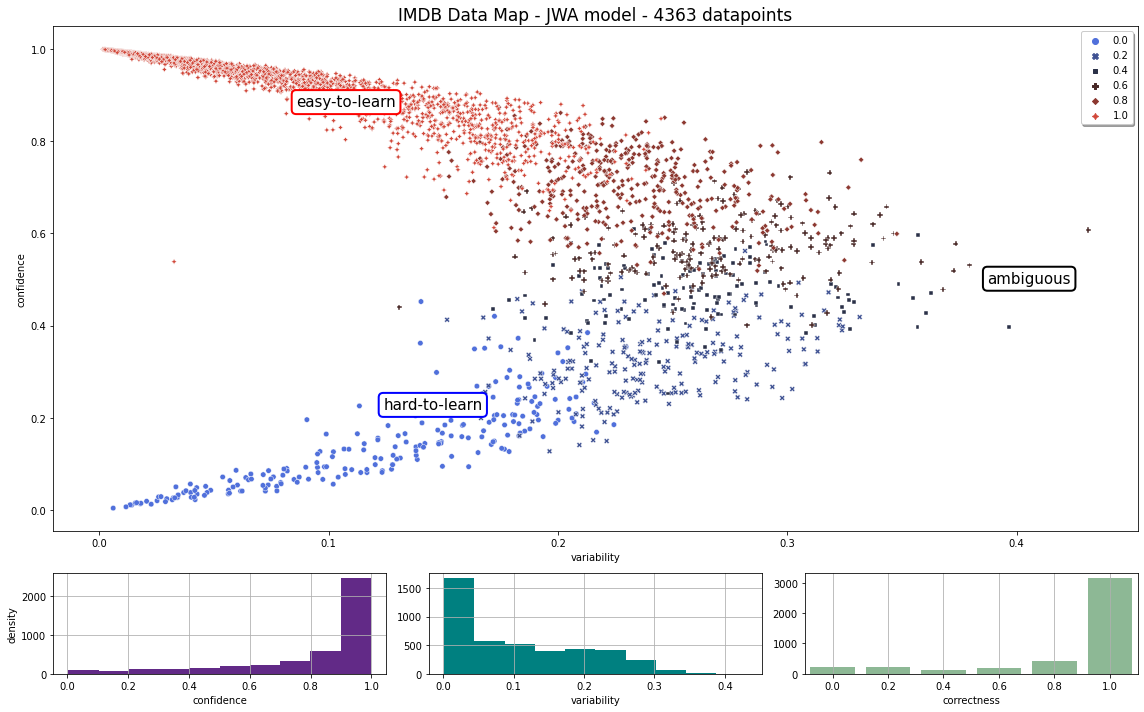

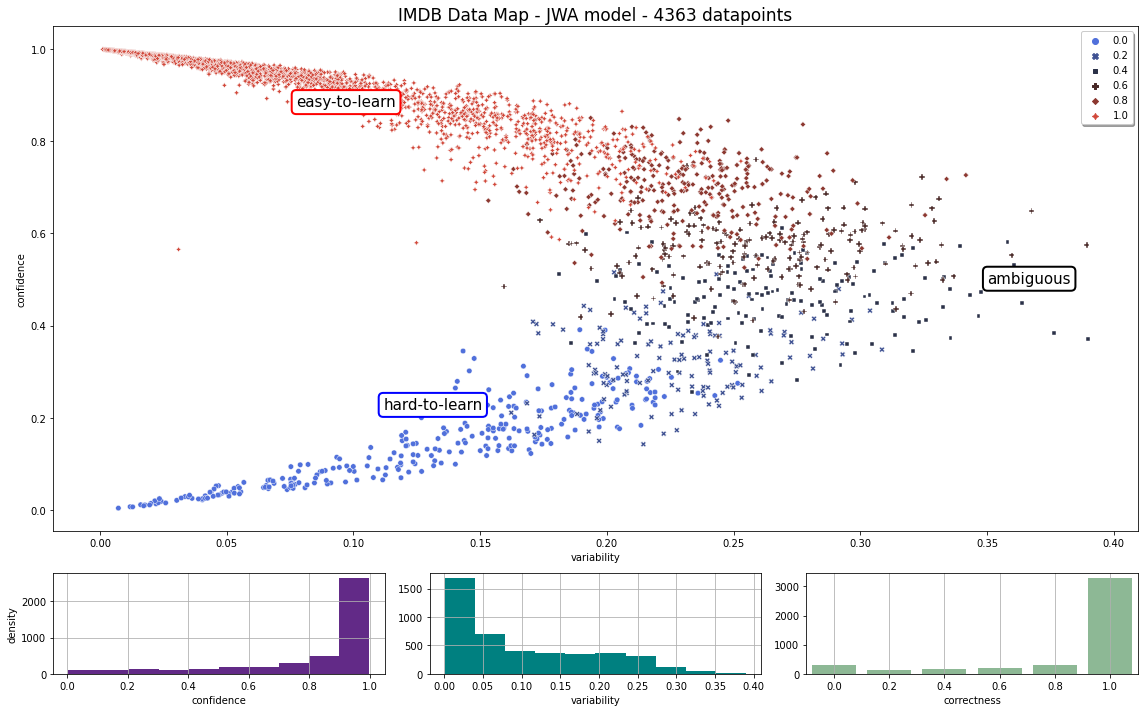

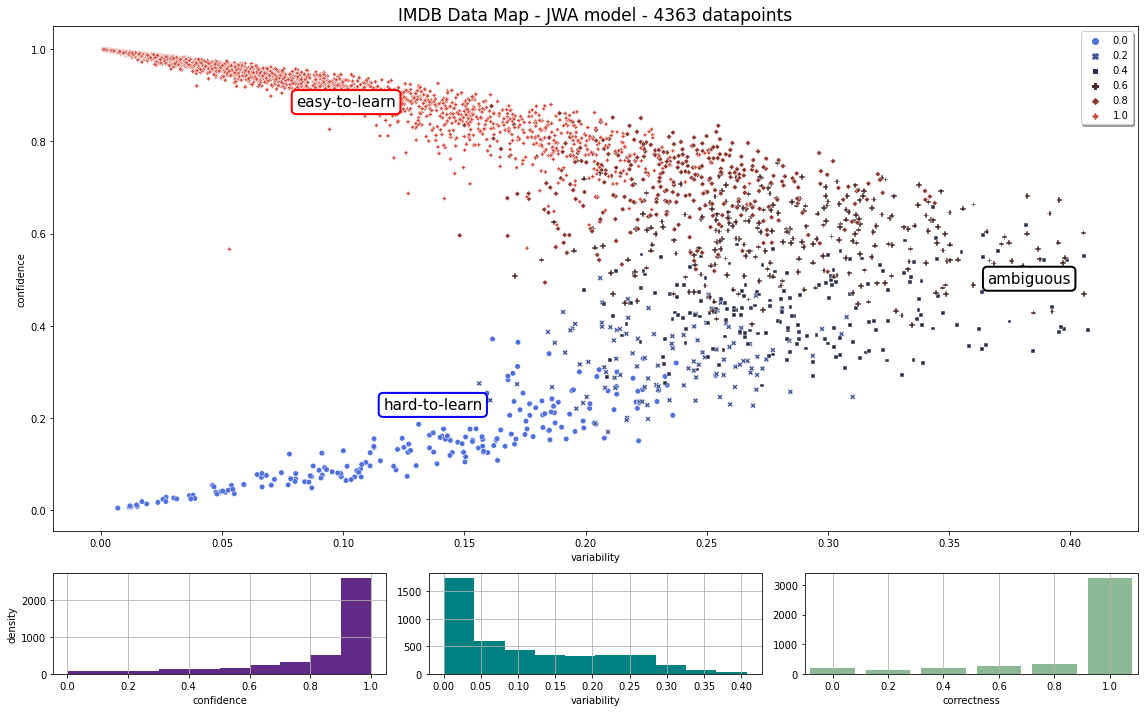

In [10]:
from IPython.display import display, clear_output
import time

df = df_crt_test
sampler = "random"
animate = lambda i: plot_cartography(df, "random", i, meta, hue_metric="correct")

for i in range(len(df[df.index.get_level_values("sampler") == sampler])):
    fig = animate(i)
    clear_output(wait=True)
    display(fig)
    time.sleep(1)
    
clear_output(wait=True)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

%matplotlib notebook

fig = plt.figure(figsize=(10, 6))


def animate(i):
    df = convert_cartography_df(df_crt_test, "random", frame)
    df = df.assign(corr_frac=lambda d: d.correctness / d.correctness.max())
    df = df.sort_values("corr_frac")
    df["correct"] = [f"{x:.1f}" for x in df["corr_frac"]]
    pal = sns.diverging_palette(
        260, 15, n=meta["epochs_per_train"] + 1, sep=10, center="dark"
    )
    graph = sns.scatterplot(
        x="variability",
        y="confidence",
        data=df,
        ax=ax0,
        hue="correct",
        palette=pal,
        style="correct",
        s=30,
    )
    plt.setp(graph.scatter)


ani = animation.FuncAnimation(
    fig, animate, frames=len(df_crt_test.index), interval=700, repeat=True
)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

fig, ax = plt.subplots(figsize=(12, 10))
s = ax.scatter([],[])
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 1)


def animate(i):
    df = convert_cartography_df(df_crt_test, "random", i)
    df = df.assign(corr_frac=lambda d: d.correctness / d.correctness.max())
    df = df.sort_values("corr_frac")
    df["correct"] = [f"{x:.1f}" for x in df["corr_frac"]]
    data = np.stack([df["variability"], df["confidence"]]).T
    s.set_offsets(data)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(df_crt_test), interval=1000)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
def plot_last_epoch(experiment, interpret_pairs):
    agreement_dict = defaultdict(list)
    train_scores = []
    eval_scores = []
    for (al_epoch, (L, A, T, E)) in enumerate(
        zip(
            experiment["labeled"],
            experiment["agreement"],
            experiment["train"],
            experiment["eval"],
        ),
        1,
    ):
        for ip in interpret_pairs:
            agreement_dict[ip].append(list(A)[-1][ip])
        train_scores.append(list(T)[-1]["loss"])
        eval_scores.append(list(E)[-1]["accuracy"] / 100)

    fig, axs = plt.subplots(3, figsize=(12, 10), sharex=True)
    axs[0].scatter(experiment["labeled"], train_scores, color="r")
    axs[0].plot(experiment["labeled"], train_scores, color="r")
    axs[0].set_ylabel("Loss")
    axs[1].scatter(experiment["labeled"], eval_scores, color="g")
    axs[1].plot(experiment["labeled"], eval_scores, color="g")
    axs[1].set_ylabel("Accuracy")
    for ip, agrs in agreement_dict.items():
        axs[2].scatter(experiment["labeled"], agrs)
        axs[2].plot(experiment["labeled"], agrs)

    axs[2].set_ylabel("Agreement")
    axs[2].set_xlabel("# labeled")
    axs[2].legend(interpret_pairs)


def plot_al_agreement(experiment_sets, meta, figsize=(12, 8), ci=90):
    fig, axs = plt.subplots(len(meta["interpret_pairs"]), figsize=figsize)
    if type(axs) is not list:
        axs = [axs]
    for ip, ax in zip(meta["interpret_pairs"], axs):
        dfs = []
        for exp_set, sampler in zip(experiment_sets, samplers):
            _, df_agr, _ = extract_last_epoch(exp_set, meta["interpret_pairs"])
            df_new = df_agr[df_agr.index.get_level_values("interpreter") == ip].copy()
            df_new["sampler"] = sampler
            dfs.append(df_new)

        agr_data = pd.concat(dfs)
        sns.lineplot(
            ax=ax,
            data=agr_data,
            x="labeled",
            y="agreement",
            hue="sampler",
            style="sampler",
            markers=True,
            dashes=False,
            picker=1,
            ci=ci,
        )
        ax.set_title(ip)


def plot_epochwise_trend(results, interpreter):
    agreements = []
    for (al_epoch, (L, A, T, E)) in enumerate(
        zip(
            results["labeled"], results["agreement"], results["train"], results["eval"]
        ),
        1,
    ):

        for a in A:
            agreement = a[interpreter]
            if np.isnan(agreement):
                agreement = 0
            agreements.append(agreement)

    plt.figure(figsize=(20, 8))
    plt.scatter(range(len(agreements)), agreements)
    plt.plot(range(len(agreements)), agreements)
    plt.vlines(
        range(len(A), len(results["labeled"]) * len(A), len(A)),
        ymin=-0.2,
        ymax=1,
        color="r",
    )
    plt.ylabel("Agreeement")
    plt.title(interpreter)